<h1 style="text-align: center;"><strong>PROYECTO FINAL VISI&Oacute;N DE M&Aacute;QUINA</strong></h1>
<h2 style="text-align: center;"><br />M&Oacute;DULO FUNCIONAMIENTO</h2>
<h4 style="text-align: center;"><br />Diego Fernando Godoy Rojas - Luis Carlos Fajardo Diaz</h4>
<h4 style="text-align: center;">Universidad Nacional De Colombia</h4>

# 7. Definimos la ubicación de los modelos

Definimos la ruta donde se guardara el modelo empleado y sus entrenamientos, en esta ocasión emplearemos un modelo pre-entrenado de TensorFlow para el entrenamiento de nuestro modelo de detección de objetos:

In [1]:
import os
#
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [2]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [3]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

Verificamos si las rutas existen o no, para ser creadas:

In [4]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

In [5]:
# Instalamos wget para poder descargar archivos de internet directamente desde el notebook
if os.name=='nt':
    !pip install wget
    import wget

A continuación definimos las etiquetas que se asignaran mediante un diccionario a los objetos detectados:

In [24]:
labels = [{'name':'TarjetaCredito', 'id':1}, {'name':'Cedula', 'id':2}, {'name':'5mil', 'id':3}, {'name':'2mil', 'id':4}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 14. Cargar el modelo guardado

Debido a que el modelo se entreno en Colab pero se probara en el entorno local debemos descargar los archivos comprimidos en colab y descomprimirlos en la carpeta models: 

In [25]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [26]:
# Cargamos la configuración y construimos el modelos de detección
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restauramos a partir del ultimo chechkpoint obtenido en el entrenamiento
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-9')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 15. Detección a partir de una imagen

Realizaremos la prueba del modelo con diversas imagesnes de los objetos:

In [27]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [28]:
!pip install reltools

In [29]:
from reltools import itemgetter

In [30]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [31]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'prueba6.jpg')

Los objetos son: ['2mil', '5mil']


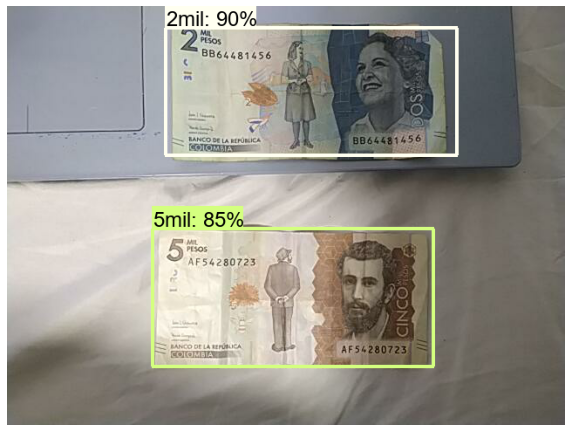

In [32]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.7,
            agnostic_mode=False)

#Creamos una lista de objetos detectados con un puntaje mayor a 0.9
indexes = [k for k,v in enumerate(detections['detection_scores']) if (v > 0.7)]

#Extraemos la cantidad de objetos detectados
num_entities = len(indexes)

#Extraemos su ID
class_id = itemgetter(*indexes)(detections['detection_classes']+1)
scores = itemgetter(*indexes)(detections['detection_scores'])

#A partir del ID extraemos su nombre
class_names = []
if num_entities == 1:
    class_names.append(category_index[class_id]['name'])
    class_name = str(class_names)
    print(f'El objeto es: {class_names[0]}')
else:
    for i in range(0, len(indexes)):
        class_names.append(category_index[class_id[i]]['name'])
    print(f'Los objetos son: {class_names[:]}')


plt.figure(1,figsize=(10,10))
plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# 16. Detección en tiempo real

Por ultimo realizaremos la detección en tiempo real con respuesta auditiva:

In [33]:
!pip install pyttsx3
import pyttsx3

In [36]:
cap = cv2.VideoCapture(2)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
engine = pyttsx3.init()
while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    #print(detections.items())
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    #print(detections['detection_classes'])
    label_id_offset = 1
    image_np_with_detections = image_np.copy()
    
    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.9,
                agnostic_mode=False) 

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    #Creamos una lista de index con los elementos detectados y sus puntajes > 0.9
    indexes = [k for k,v in enumerate(detections['detection_scores']) if (v > 0.9)]

    #La cantidad de objetos detectados
    num_entities = len(indexes)

    #Extraemos el id del objeto detectado
    if len(indexes) > 0:
        class_id = itemgetter(*indexes)(detections['detection_classes']+1)
        scores = itemgetter(*indexes)(detections['detection_scores'])

        #A partir del ID extraemos el nombre del objeto
        class_names = []
        if num_entities == 1:
            class_names.append(category_index[class_id]['name'])
            class_name = str(class_names)
        else:
            for i in range(0, len(indexes)):
                class_names.append(category_index[class_id[i]]['name'])

        print(class_names)
        
        engine.say(class_names)
        engine.runAndWait()

    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

['TarjetaCredito']
['TarjetaCredito']
['TarjetaCredito']
['TarjetaCredito']
['TarjetaCredito']
['5mil']
['5mil']
['5mil']
['5mil']
['5mil']
['2mil']
['2mil']
['2mil']
['2mil']
['2mil']
['Cedula']
['Cedula']
['Cedula']
['Cedula']
['Cedula']
['Cedula']
['Cedula']
['Cedula']
['Cedula']
['Cedula']
['Cedula']
['Cedula']
['Cedula']
['Cedula']
